# Práctica: Un detector de bordes completo

En esta práctica vamos a desarrollar un detector completo de bordes que, partiendo de lo que hemos visto en clase, trate de obtener una imagen real de bordes con todas sus características. Para que un detector de bordes sea útil, debe cumplir las siguientes características:
- Mininimizar el número de falsos positivos
- Localizar los bordes de la forma más precisa posible
- Detectar un único píxel (de grosor) para cada borde

Para ello, vamos a tratar de implementar los siguientes pasos: 
- filtro de suavizado para la eliminación de ruido
- detección de bordes mediante el cálculo del gradiente
- supresión de no máximos
- umbralización y rellenado de huecos 

In [4]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

### Paso 1: filtro de suavizado para la eliminación de ruido

Implementa una función que reciba como parámetros una imagen y una máscara y realice la convolución de dicha imagen con la máscara. El algoritmo de detección de bordes deberá aplicar un filtro guassiano de dimensión establecida por el usuario. Puedes generar fácilmente una máscara de convolución gaussiana de la siguiente manera.

In [5]:
n = 11 #tamaño del filtro
sigma = 3 #desviación de la gaussiana
mask = cv2.getGaussianKernel(n, sigma)*cv2.getGaussianKernel(n, sigma).T
mask.shape

(11, 11)

In [6]:
def filtro(imagen, mascara):
    n,m  = mascara.shape[0]//2, mascara.shape[1]//2
    imagen_ampliada = cv2.copyMakeBorder(imagen, n, n, m, m, cv2.BORDER_REPLICATE)
    imagen_fil = np.zeros_like(imagen)
    
    for i in range(n, imagen_ampliada.shape[0]-n):
        for j in range(m, imagen_ampliada.shape[1]-m):
            ventana = imagen_ampliada[i-n:i+n+1, j-m:j+m+1]
            imagen_fil[i-n,j-m] = np.sum(ventana*mascara)
    return imagen_fil

(-0.5, 397.5, 352.5, -0.5)

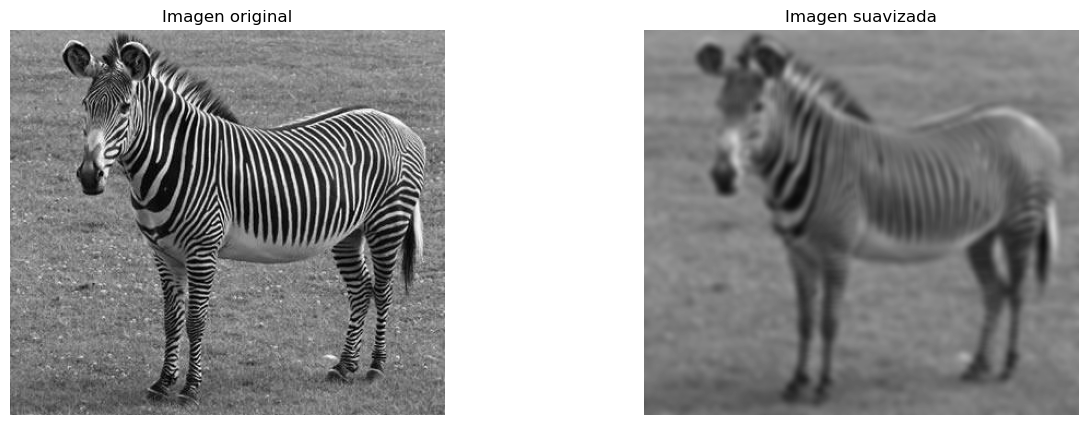

In [7]:
imagen = cv2.imread('images/cebra.jpg', 0)
mask = cv2.getGaussianKernel(n, sigma)*cv2.getGaussianKernel(n, sigma).T
imagen_fil = filtro(imagen, mask)

fig, axes = plt.subplots(1,2,figsize=(15,5))

axes[0].imshow(imagen, cmap='gray', vmin=0, vmax=255)
axes[1].imshow(imagen_fil, cmap='gray', vmin=0, vmax=255)
axes[0].set_title('Imagen original')
axes[1].set_title('Imagen suavizada')
axes[0].axis('off')
axes[1].axis('off')

In [6]:
cv2.imshow('Imagen suavizada',np.uint8(imagen_fil))
cv2.waitKey(0)
cv2.destroyAllWindows()

### Paso 2: detección de bordes mediante el cálculo del gradiente

Implementa una función que reciba como parámetro la imagen y devuelva una nueva imagen de magnitudes y orientaciones de gradiente. Para calcularlas, necesitarás calcular la derivada parcial en x y en y por cada píxel mediante las máscaras de convolución

m_g_x = [[-1, -2, -1], [0, 0, 0], [1, 2, 1]]
m_g_y = [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]

A partir de las dos imágenes obtenidas, obtén la imagen de magnitudes aplicando 

$$E(u,v)=\sqrt{I_x (u,v)^2+I_y (u,v)^2 }$$
y la imagen de orientaciones aplicando 

$$\Phi(u,v)=atan2(I_y (u,v),I_x (u,v))$$

Puedes utilizar las funciones np.arctan2 y np.rad2deg. Puedes utilizar la llamada a la función filtro_suavizado (ojo con devolver valores uint). Para obtener magnitudes y gradientes no es necesario ningún bucle for!

In [3]:
def gradiente(imagen):
    imagen_fil = filtro(imagen, mask).astype(np.float32)
    m_g_x = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    m_g_y = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

    I_x = filtro(imagen_fil, m_g_x)
    I_y = filtro(imagen_fil, m_g_y)

    E = np.sqrt(I_x**2 + I_y**2)
    Phi = np.rad2deg(np.arctan2(I_y, I_x))
    return E, Phi

In [4]:
E, phi = gradiente(imagen)

fig, axes = plt.subplots(1,1,figsize=(15,5))

axes.imshow(E, cmap='gray', vmin=0, vmax=255)
axes.set_title('Magnitudes')
axes.axis('off')


NameError: name 'imagen' is not defined

In [ ]:
cv2.imshow('Magnitudes',E/E.max())
cv2.waitKey(0)
cv2.destroyAllWindows()

: 

### Paso 3: supresión de no máximos

Para localizar los bordes de la manera más precisa posible, vamos a aplicar una supresión de no máximos sobre las magnitudes de los bordes. La supresión de no máximos va a hacer que mantengamos únicamente aquellos bordes cuya magnitud sea máxima a lo largo de la dirección del gradiente. 

Recuerda que los cambios de intensidad van ocurriendo, normalmente, de manera paulatina. Si analizamos, por ejemplo,. los píxeles de la línea roja, todos van a tener una magnitud diferente, pero el gradiente apunta aproximadamente en la misma dirección en todos ellos.

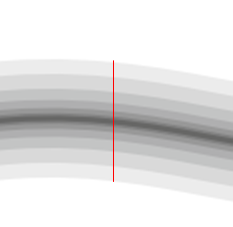

A lo largo de la dirección de dicho gradiente vamos a eliminar todos aquellos que no sean un máximo local.

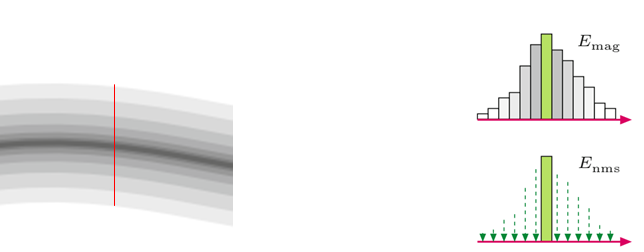

Sin embargo, no todo es tan sencillo como parece. El problema de la supresión de no máximos es la discontinuidad de los ángulos en $\Phi$, ya que existe mucha variación entre un píxel y sus vecinos. Para ello, necesitamos una forma de discretizar y simplificar las posibles direcciones de gradientes.

Para ello, vamos a utilizar una ruleta de gradientes. Básicamente, vamos a modificar el valor de $\Phi(u,v)$ por un valor discreto (1, 2, 3 o 4) en función de la siguiente ruleta:

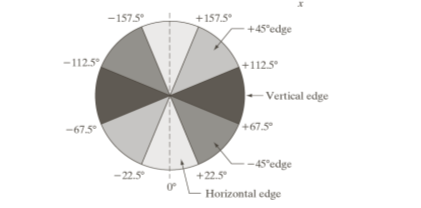

Por ejemplo, si asumimos que el 1 representa los gradientes verticales, entonces todos aquellos valores de $\Phi$ que valgan entre -22.5 y 22.5 o bien sean menores de -157.5 o bien sean mayores de 157.5 los modificaremos por el valor 1. 

Implementa la función ruleta de tal manera que devuelva una matriz del mismo tamaño que $\Phi$ pero con valores entre 1 y 4 siguiendo la ruleta. Puedes elegir qué representa el 2, el 3 o el 4, ya que es una representación que elegimos de manera arbitraria. 

In [ ]:
def ruleta(phi):

    #phi_d = (((phi+22.5)//45).astype(np.uint8) % 4) + 1
    mask1 = ((phi > -22.5) & (phi < 22.5)) | (phi < -157.5) | (phi > 157.5) # 1
    mask2 = ((phi > 112.5) & (phi <= 157.5)) | ((phi <= -22.5) & (phi > -67.5)) # 2
    mask3 = ((phi > 67.5) & (phi <= 112.5)) | ((phi <= -67.5) & (phi > -112.5)) # 3
    mask4 = ((phi >= 22.5) & (phi <= 67.5)) | ((phi <= -112.5) & (phi >= -157.5)) # 4

    phi_d = np.zeros_like(phi)
    phi_d[mask1] = 1
    phi_d[mask2] = 2
    phi_d[mask3] = 3
    phi_d[mask4] = 4

    unique, counts = np.unique(phi_d, return_counts=True)
    print(dict(zip(unique, counts)))
    return phi_d

(353, 398)


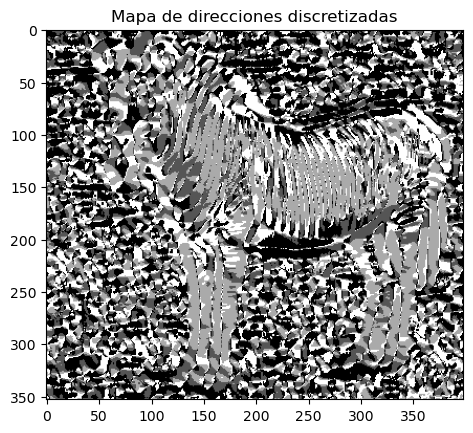

In [20]:
phi_d = ruleta(phi)

print(phi_d.shape)
plt.imshow(phi_d, cmap='gray')
plt.title('Mapa de direcciones discretizadas')
plt.show()

In [ ]:
cv2.imshow('Discretizados',phi_d/phi_d.max())
cv2.waitKey(0)
cv2.destroyAllWindows()

: 

Una vez tengas los ángulos discretizados, toca aplicar la supresión de no máximos. Dada un píxel $(u,v)$, su magnitud $E(u,v)$ y la discretización de su angulo $\Phi_d(u,v)$, entonces:
- si $E(u,v)$ es mayor o igual que sus vecinos en la dirección del gradiente (discretizado), entonces $E_g(u,v)=E(u,v)$
- si no, $E_g(u,v)=0$

Así, por ejemplo, si $\Phi_d(u,v)=1$ (borde vertical), entonces debemos comparar $E(u,v)$ con los píxeles vecinos en dicha dirección, es decir, $E(u-1,v)$ y $E(u+1,v)$. Si su valor es mayor o igual que el de los vecinos, entonces mantenemos su magnitud. Si no, la suprimimos, ya que no es un máximo en esa dirección.

In [ ]:
def supresion_no_maximos(E, phi_d):

    E_amp = cv2.copyMakeBorder(E, 1, 1, 1, 1, cv2.BORDER_REPLICATE)
    E_g = np.zeros_like(E)

    vertical = (phi_d == 1)
    diag45 = (phi_d == 2)
    horizontal = (phi_d == 3)
    diag135 = (phi_d == 4)

    # Vertical (arriba y abajo)
    E_g[vertical] = E[vertical] * (
        (E_amp[1:-1, 1:-1][vertical] >= E_amp[:-2, 1:-1][vertical]) &
        (E_amp[1:-1, 1:-1][vertical] >= E_amp[2:, 1:-1][vertical])
    )

    # Diagonal 45° (superior derecha / inferior izquierda)
    E_g[diag45] = E[diag45] * (
        (E_amp[1:-1, 1:-1][diag45] >= E_amp[:-2, 2:][diag45]) &
        (E_amp[1:-1, 1:-1][diag45] >= E_amp[2:, :-2][diag45])
    )

    # Horizontal (izquierda y derecha)
    E_g[horizontal] = E[horizontal] * (
        (E_amp[1:-1, 1:-1][horizontal] >= E_amp[1:-1, :-2][horizontal]) &
        (E_amp[1:-1, 1:-1][horizontal] >= E_amp[1:-1, 2:][horizontal])
    )

    # Diagonal 135° (superior izquierda / inferior derecha)
    E_g[diag135] = E[diag135] * (
        (E_amp[1:-1, 1:-1][diag135] >= E_amp[:-2, :-2][diag135]) &
        (E_amp[1:-1, 1:-1][diag135] >= E_amp[2:, 2:][diag135])
    )
    
    return E_g
    

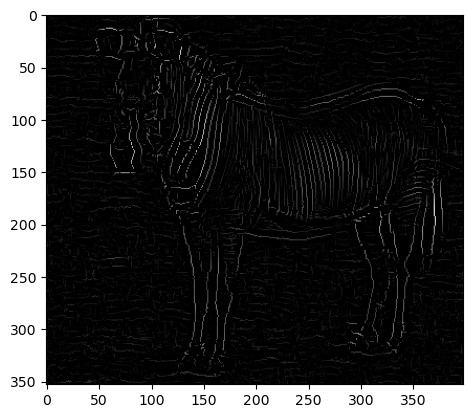

In [31]:
E_g = supresion_no_maximos(E, phi_d)

plt.imshow(E_g, cmap='gray')
plt.show()

In [ ]:
cv2.imshow('Magnitudes',E/E.max())
cv2.imshow('Magnitudes suprimidas',E_g/E_g.max())
cv2.waitKey(0)
cv2.destroyAllWindows()

### Paso 4: umbralización y rellenado de huecos

La detección final de contornos se realiza mediante una doble umbralización, seguida de un rellenado de huecos. La doble umbralización trata de de distinguir las magnitudes que han superado la supresión de no máximos en dos grupos:
- aquellas magnitudes que seguro acabarán siendo borde porque su valor es muy alto
- aquellas que tienen un valor relativamente alto y podrían ser bordes
- aquellas que tienen un valor bajo y no serán bordes. 

Para ello, debes calcular los umbrales $q_l$ y $q_h$ de manera que $q_l$ sea el el 10% del valor máximo de $E_g$ y $q_h$ sea el el 30% del valor máximo. Una vez calculados, devuelve dos nuevas matrices de la misma dimensión que $E_g$. La matriz $E_{nh}$ tendrá valores a 1 en aquellas posiciones de $E_g$ que sean mayores o iguales que $q_h$ (y cero en el resto). La matriz $E_{nl}$ tendrá valores a 1 en aquellas posiciones mayores o iguales que $q_l$ y menores que $q_h$. 




In [32]:
def umbralizacion(E_g):

    ql = 0.1 * np.max(E_g)
    qh = 0.3 * np.max(E_g)

    E_nh = (E_g >= qh).astype(np.uint8)  # Bordes fuertes
    E_nl = ((E_g >= ql) & (E_g < qh)).astype(np.uint8)  # Bordes débiles
    
    return E_nh, E_nl

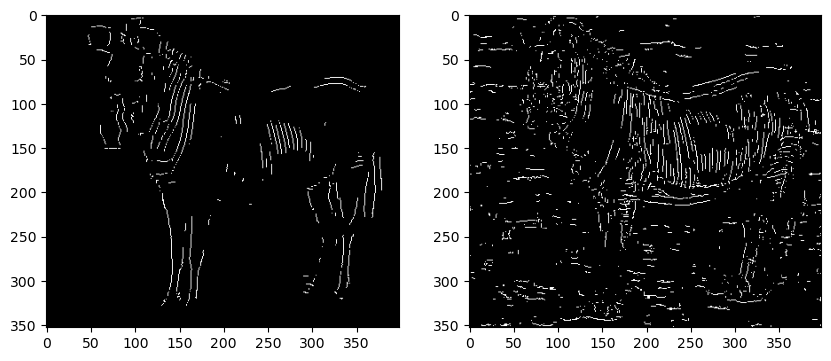

In [35]:
E_nh, E_nl = umbralizacion(E_g)


fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].imshow(E_nh, cmap='gray')
axes[1].imshow(E_nl, cmap='gray')



plt.show()

In [ ]:
cv2.imshow('E_nh',E_nh)
cv2.imshow('E_nl',E_nl)
cv2.waitKey(0)
cv2.destroyAllWindows()

Por último tocaría el rellenado de huecos, que consiste en ir complementando la matriz $E_{nh}$ con aquellos píxeles de $E_{nl}$ que estén lo suficientemente cerca de un píxel de $E_{nh}$. Para ello, vamos a hacer una aproximación iterativa:
- Empezamos visitando un píxel de $E_{nh}$, por ejemplo el $(u,v)$
- Marcaremos a 1 (en $E_{nh}$ todos aquellos píxeles vecinos de $(u,v)$ que en $E_{nl}$ tengan un valor a 1
- Visitamos el siguiente píxel de $E_{nh} y repetimos el proceso hasta visitar todos sus píxeles.

In [38]:
def rellenado(E_nh, E_nl):
    
    contornos = np.zeros((E_nh.shape[0]+2,E_nh.shape[1]+2))
    
    E_nh_amp = cv2.copyMakeBorder(E_nh, 1, 1, 1, 1, cv2.BORDER_CONSTANT, 0)
    E_nl_amp = cv2.copyMakeBorder(E_nl, 1, 1, 1, 1, cv2.BORDER_CONSTANT, 0)
    
    while np.sum(E_nh_amp)>0:
        p = np.nonzero(E_nh_amp)
        x, y = p[0][0], p[1][0]
        contornos[x, y] = 1
        contornos[x-1:x+2, y-1:y+2] = np.logical_or(contornos[x-1:x+2, y-1:y+2] , E_nl_amp[x-1:x+2, y-1:y+2])
        
        E_nh_amp[x,y] = 0
        
    
    return contornos[1:-2,1:-2]
    

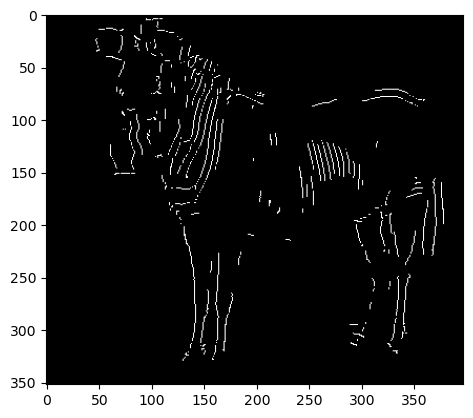

In [40]:
contornos = rellenado(E_nh, E_nl)

plt.imshow(contornos, cmap='gray')
plt.show()

In [ ]:
cv2.imshow('Contornos',contornos)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [41]:
E_nh.sum(), contornos.sum()

(2482, 2720.0)

### Detector completo

In [43]:
def detector(imagen, n):
    # Genera una máscara gaussiana y obtén la imagen filtrada
    mask = cv2.getGaussianKernel(n, sigma)*cv2.getGaussianKernel(n, sigma).T
    mask_gauss = filtro(imagen, mask)

    # Genera las imágenes de magnitudes y orientaciones del gradiente
    E, phi = gradiente(mask_gauss)
    phi_d = ruleta(phi)
    
    # Realiza la supresión de no máximos
    E_g = supresion_no_maximos(E, phi_d)

    # Umbraliza y obtén la imagen final de contornos

    E_nh, E_nl = umbralizacion(E_g)
    imagen_contornos = rellenado(E_nh, E_nl)

    return imagen_contornos
    

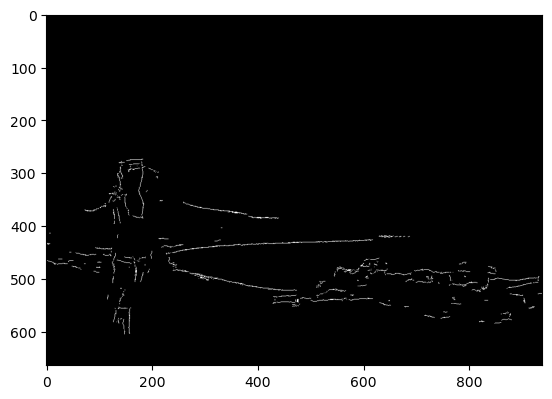

In [51]:
n = 11 #tamaño del filtro
imagen = cv2.imread('images/playa.jpg', 0)
imagen_cont = detector(imagen, n)

plt.imshow(imagen_cont, cmap='gray')
plt.show()